# Royal Caribbean Data Analytics & AI Assessment

<u>Candidate Name:</u> Justin Bell  
<u>Date Completed:</u> March 5, 2023

## Part 1: SQL Queries

The relational database used for answering questions in this part is shwon below.

from IPython.display import Image
Image(filename='relational_db.png')
<center><img src="relational_db.png"/></center>

### Q1: Report the total number of sales orders processed last month. (The month before current). Today’s date is 2020-01-23.

In [ ]:
# Define the parameters for the query.
params = {
    "PARAM_SALES_ORDER": "fact_sales_order",  # Table name for sales orders.
    "PARAM_MONTH": "December",  # Month for which to count sales.
    "PARAM_YEAR": 2019  # Year for which to count sales.
}

# SQL query using f-string so parameters can be easily changed.
query = f'''
SELECT COUNT(sales_order_number) AS total_number_sales
FROM {params['PARAM_SALES_ORDER']}
LEFT JOIN dim_date
USING (date_key)
WHERE dim_date.month_name = '{params['PARAM_MONTH']}'
    AND dim_date.year = {params['PARAM_YEAR']}
'''

### Q2: Rank my store sales (sale_subtotal) based on sales that occured last month. (The month before current). Today’s date is 2020-01-23. Please report the store name and city the store is located in your query.

In [ ]:
'''

SELECT b.store_name, b.city,
    RANK()
        OVER (ORDER BY a.store_sales DESC) AS sales_rank
FROM (
    SELECT store_key, SUM(sale_subtotal) AS store_sales
    FROM fact_sales_order
    LEFT JOIN dim_date
    USING (date_key)
    WHERE dim_date.month_name = 'December' AND dim_date.year = 2019
    GROUP BY store_key
) AS a
LEFT JOIN dim_store AS b
USING (store_key)

'''
# Doing a RIGHT JOIN at the end here would assure all stores are represented, but would that put NULLs
# if store isn't in the fact_sales_order and how would RANK deal with that row? Could I add a condition to make it rank last?

"\n\nSELECT b.store_name, b.city,\n    RANK()\n        OVER (ORDER BY a.store_sales DESC) AS sales_rank\nFROM (\n    SELECT store_key, SUM(sale_subtotal) AS store_sales\n    FROM fact_sales_order\n    LEFT JOIN dim_date\n    USING (date_key)\n    WHERE dim_date.month_name = 'December' AND dim_date.year = 2019\n    GROUP BY store_key\n) AS a\nLEFT JOIN dim_store AS b\nUSING (store_key)\n\n"

In [ ]:
# Only one left to check

params = {
    "PARAM_SALES_ORDER": "fact_sales_order", # Table name for sales orders.
    "PARAM_DATE": dt(2020, 1, 23) # Current date.
}
query = f"""
SELECT b.store_name, b.city,
    RANK() OVER (ORDER BY COALESCE(a.store_sales, 0) DESC) AS sales_rank
FROM (
    SELECT store_key, SUM(sale_subtotal) AS store_sales
    FROM {params['PARAM_SALES_ORDER']}
    LEFT JOIN dim_date
    USING (date_key)
    WHERE EXTRACT(MONTH FROM dim_date.date_key) =
        CASE
            WHEN DATE '{params['PARAM_DATE']}' >= DATE '{params['PARAM_DATE'].year}-02-01' THEN 1
            ELSE EXTRACT(MONTH FROM ADD_MONTHS(DATE '{params['PARAM_DATE']}', -1))
        END
        AND EXTRACT(YEAR FROM dim_date.date_key) =
        CASE
            WHEN EXTRACT(MONTH FROM dim_date.date_key) = 1 AND DATE '{params['PARAM_DATE']}' < DATE '{params['PARAM_DATE'].year}-01-01' THEN {params['PARAM_DATE'].year} - 1
            ELSE {params['PARAM_DATE'].year}
        END
    GROUP BY store_key
) AS a
RIGHT JOIN dim_store AS b
USING (store_key)
"""
#### The query then uses a CASE statement within the WHERE clause to filter for sales that occurred in the previous month.

#The CASE statement checks if the current date is on or after February 1st, in which case the previous month is January, and returns 1 as the month number. Otherwise, it uses the ADD_MONTHS function to subtract 1 month from the current date and extract the month number of the resulting date.

#The CASE statement is also used to check if the year should be the same as the current year or the previous year, based on the month number obtained from the previous CASE statement.

#The EXTRACT function is used to extract the month and year from the date key in the dim_date table. The rest of the query is the same as before.

NameError: name 'dt' is not defined

### Q3: Since the beginning of this year, which employee has the most unique sales?

In [ ]:
params = {
    "PARAM_SALES_ORDER": "fact_sales_order",  # Table name for sales orders.
    "PARAM_YEAR": 2020 # Year for which to count sales.
}

query = f'''
SELECT b.employee_name
FROM (
    SELECT employee_key, COUNT(sales_order_number) AS employee_sales_count
    FROM {params['PARAM_SALES_ORDER']}
    LEFT JOIN dim_date
    USING (date_key)
    WHERE dim_date.year = {params['PARAM_YEAR']}
    GROUP BY employee_key
) AS a
LEFT JOIN dim_employee AS b
USING (employee_key)
ORDER BY employee_sales_count DESC
LIMIT 1
'''

## Part 2: Exploratory Data Analysis

In the zip file you will find a dataset called satistfaction.csv This dataset contains information
about airline passengers, their trip, and whether or not they were satisfied. This data is from
a survey so make the assumption that a higher number is better in columns like ‘Ease of Online
booking’. The satisfied_v2 column is something that is a verified customer sentiment via customer
service representatives reaching out to the customer.  

**Your business leaders have asked you to investigate how big of a problem we have with
unsatisfied passengers as well as what might be causing it.**  

In this part, we ask that you perform an exploratory data analysis into the dataset while also
trying to answer the business leaders’ question. Feel free to be as concise or as thorough as you’d
like.

First, we'll do some data cleaning before making visuals.

In [ ]:
# Import libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Read in excel data and view first few rows.
df = pd.read_excel(r'Copy of satisfaction(9146).xlsx')
df.head()

,id,satisfaction_v2,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,117135,satisfied,Male,disloyal Customer,56,Personal Travel,Eco,369,0,2,...,3,3,1,5,3,3,4,3,0,0.0
1,72091,satisfied,Male,disloyal Customer,49,Personal Travel,Eco,2486,0,2,...,3,2,1,1,4,4,3,2,0,0.0
2,29663,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,1448,0,3,...,3,3,3,5,3,2,3,3,0,0.0
3,81849,satisfied,Female,disloyal Customer,36,Personal Travel,Eco,1501,0,4,...,4,4,5,4,5,5,5,4,0,0.0
4,83693,satisfied,Male,disloyal Customer,55,Personal Travel,Eco,577,0,5,...,3,3,3,4,5,3,4,3,0,0.0


In [ ]:
# Check size of data.
df.shape

(129880, 24)

Looks like everything was imported correctly.

In [ ]:
# Check data types for each feature.
df.dtypes

id                                     int64
satisfaction_v2                       object
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

All of our features appear to have the correct data type assigned to them.

In [ ]:
# View number of unique values for each feature.
df.nunique()

id                                   129880
satisfaction_v2                           2
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3821
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

Everything looks good here. It's worth noting that the 'Baggage handling' feature has ones less unique value than the other 0-5 scale features. This most likely means that the 'Baggage handling' feature does not have any zeros. Let's check this.

In [ ]:
# View counts of each value for the Baggage handling feature.
df['Baggage handling'].value_counts()

4    46761
5    33878
3    25851
2    14362
1     9028
Name: Baggage handling, dtype: int64

As hypothesized, 'Baggage handling' does not contain any scores of 0. We'll assume that this wasn't an option in the survey. Next, let's take a look to see if our data has any null values and determine the appropriate action to handle them.

In [ ]:
# Check to see which columns, if any, have null values and how many there are.
df_nulls = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
df_nulls.columns = ['count', '%']
df_nulls.sort_values(by=['count', '%'], ascending=False)

,count,%
Arrival Delay in Minutes,393,0.302587
id,0,0.000000
satisfaction_v2,0,0.000000
Gender,0,0.000000
Customer Type,0,0.000000
Age,0,0.000000
Type of Travel,0,0.000000
Class,0,0.000000
Flight Distance,0,0.000000
Inflight wifi service,0,0.000000


Fortunately, most of our features don't have any missing values! Even better, the only feature that does, 'Arrival Delay in Minutes', has very few relative to the size of our dataset. Since 0.30% is very small, we will simply drop these rows for our analysis rather than impute values.

In [ ]:
# Drop all rows with null values and check the size of our new dataframe.
df = df.dropna()
df.shape

(129487, 24)

Now our data has no missing values. It's also worth noting that we are not worried about duplicates because the id column is unique. Let's now split our data by 'satisfaction_v2' and start creating some visuals to help us better understand our data.

In [ ]:
# Splitting data by 'satisfaction_v2'.
df_s = df[df['satisfaction_v2']=='satisfied']
df_d = df[df['satisfaction_v2']=='neutral or dissatisfied']

In [ ]:
# Check to make sure all data is split properly.
df_s.shape[0] + df_d.shape[0]

129487

This looks good. Let's take a look at some descriptive statistics for our data.

In [ ]:
# View descriptive statistics for numerical features.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,129487.0,64958.335169,37489.781165,1.0,32494.5,64972.0,97415.5,129880.0
Age,129487.0,39.428761,15.117597,7.0,27.0,40.0,51.0,85.0
Flight Distance,129487.0,1190.210662,997.560954,31.0,414.0,844.0,1744.0,4983.0
Inflight wifi service,129487.0,2.728544,1.329235,0.0,2.0,3.0,4.0,5.0
Departure/Arrival time convenient,129487.0,3.057349,1.526787,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,129487.0,2.756786,1.401662,0.0,2.0,3.0,4.0,5.0
Gate location,129487.0,2.976909,1.278506,0.0,2.0,3.0,4.0,5.0
Food and drink,129487.0,3.204685,1.329905,0.0,2.0,3.0,4.0,5.0
Online boarding,129487.0,3.252720,1.350651,0.0,2.0,3.0,4.0,5.0
Seat comfort,129487.0,3.441589,1.319168,0.0,2.0,4.0,5.0,5.0


These values make sense for the features overall. The only thing that stands out is the minimum 'Flight Distance' being 31.0 miles, which is rather small, albeit possible.

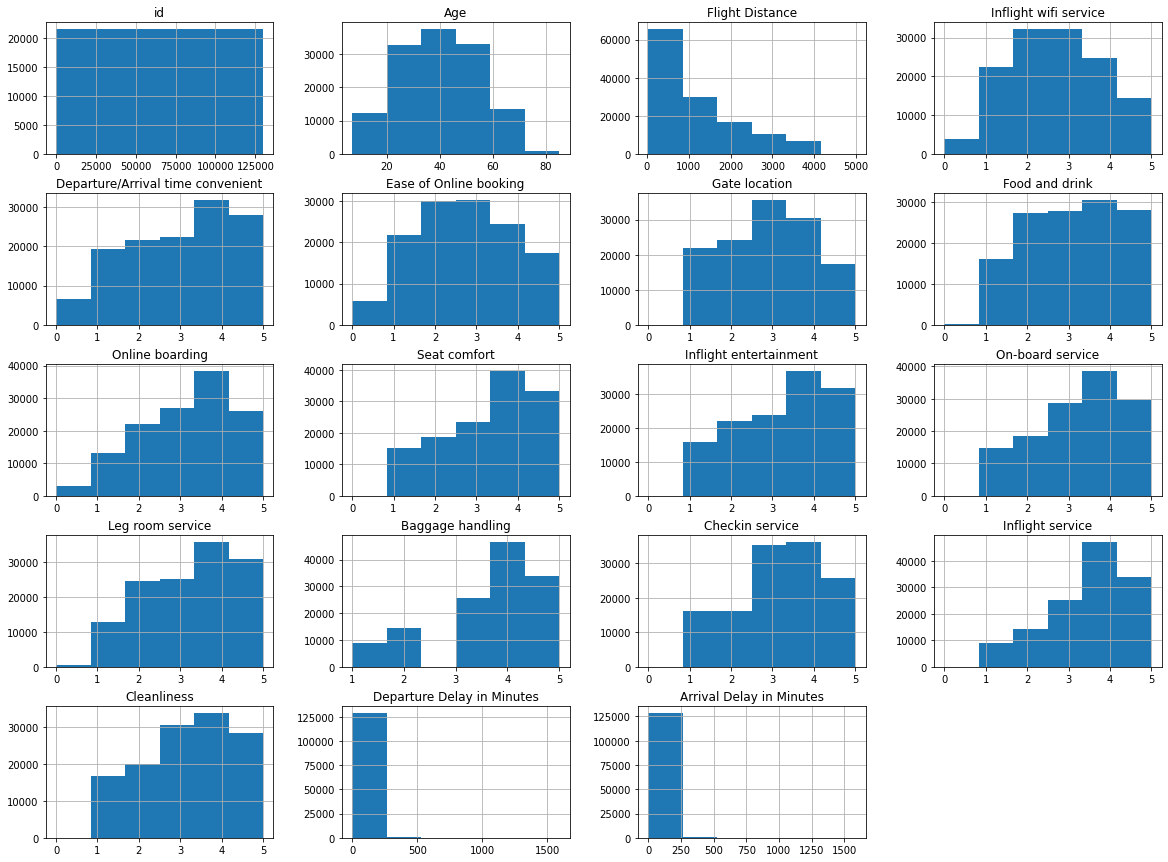

In [ ]:
# Histogram for all numerical features in our pre-split data.
_ = df.hist(bins = 6, figsize = (20,15)) # Chose 6 bins for the many features with values 0-5.

It looks like we have some potential outliers for 'Flight Distance', 'Departure Delay in Minutes', and 'Arrival Delay in Minutes'. Let's take a closer look at these distributions by building some boxplots with our split data.

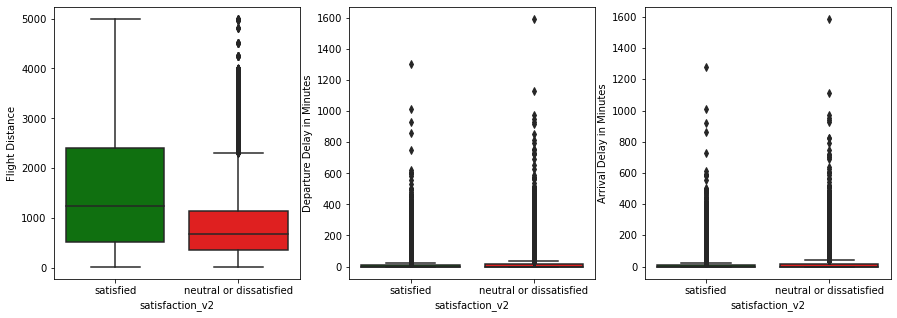

In [ ]:
# Side-by-side boxplots by 'satisfaction_v2'.
fig, ax = plt.subplots(1, 3, figsize = (15,5))

colors = ['green', 'red']
_ = sns.boxplot(ax = ax[0], x = 'satisfaction_v2', y = 'Flight Distance', data = df, palette = colors)
_ = sns.boxplot(ax = ax[1], x = 'satisfaction_v2', y = 'Departure Delay in Minutes', data = df, palette = colors)
_ = sns.boxplot(ax = ax[2], x = 'satisfaction_v2', y = 'Arrival Delay in Minutes', data = df, palette = colors)

The outliers here are determined by $Q1-(1.5 * IQR)$ and $Q3+(1.5 * IQR)$.

In regards to 'Flight Distance', we can see that for satisfied customers there are no outliers. The outliers for neutral or dissatisfired customers are feasible, as they fall in the same range as satisfied customers. For the delay features, it makes sense that there would be many outliers due to most flights not being delayed at all, resulting in a value of 0. These values are also feasible, so we can leave them as is.

Let's take a quick look at the boxplots for 'Age'.

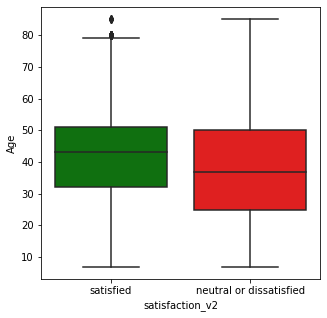

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

_ = sns.boxplot(x = 'satisfaction_v2', y = 'Age', data = df, palette = colors)

Age doesn't seem to have too much of an impact on customer satisfaction, but younger people tend to be more neutral or dissatisfied thand older people. The outliers for satisfied customers are certainly feasible and will be left in.

In [ ]:
# stacked bar charts green/red to compare numeric 0-5 scale features
#df['Inflight wifi service'].plot(kind='bar')

In [ ]:
#plt.bar(df['Inflight wifi service'], height=1)

Now let's take a look at our categorical features and how they compare based on customer satisfaction.

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\justi\anaconda3\lib\si

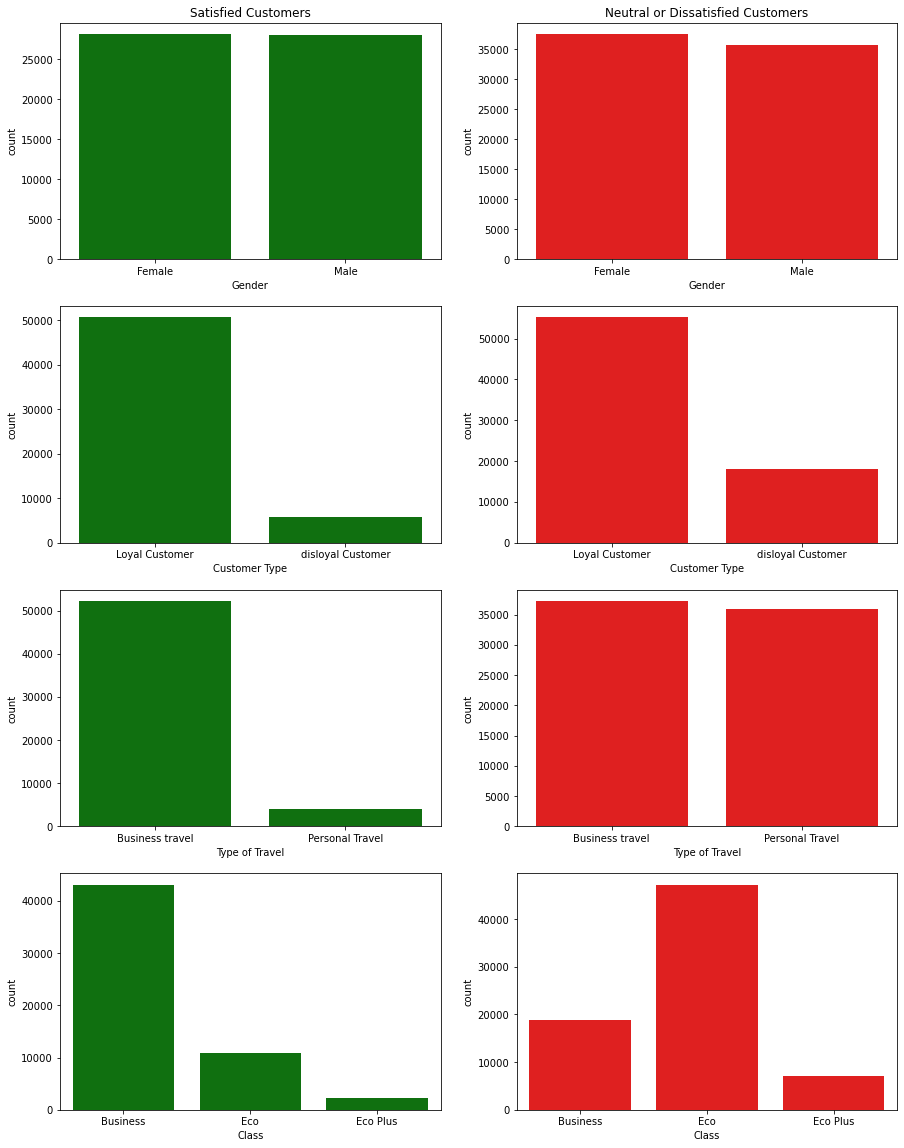

In [ ]:
# Side-by-side countplots by 'satisfaction_v2'.
fig, ax = plt.subplots(4, 2, figsize = (15,20))

_ = sns.countplot(df_s['Gender'].sort_values(), ax=ax[0,0], palette=['green'])
_ = sns.countplot(df_d['Gender'].sort_values(), ax=ax[0,1], palette=['red'])
_ = sns.countplot(df_s['Customer Type'].sort_values(), ax=ax[1,0], palette=['green'])
_ = sns.countplot(df_d['Customer Type'].sort_values(), ax=ax[1,1], palette=['red'])
_ = sns.countplot(df_s['Type of Travel'].sort_values(), ax=ax[2,0], palette=['green'])
_ = sns.countplot(df_d['Type of Travel'].sort_values(), ax=ax[2,1], palette=['red'])
_ = sns.countplot(df_s['Class'].sort_values(), ax=ax[3,0], palette=['green'])
_ = sns.countplot(df_d['Class'].sort_values(), ax=ax[3,1], palette=['red'])
ax[0,0].title.set_text('Satisfied Customers')
ax[0,1].title.set_text('Neutral or Dissatisfied Customers')

Gender doesn't appear to have much of an impact on customer satisfaction. Disloyal customers are slightly more likely to be neutral or dissatisfied. Personal travel customers are much more likely to be neutral or dissatisfied. Business class customers are more likely to be satisfied, while Economy class customers are more likely to be neutral or dissatisfied. Economy plus customers are slightly more likely to be neutral or dissatisfied.

C:\Users\justi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


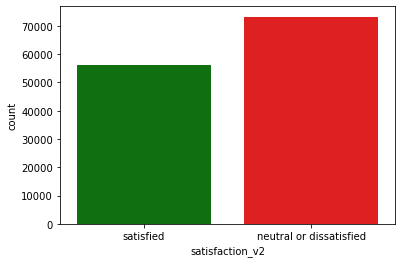

In [ ]:
# Let's take a look at the distribution of our target, 'satisfaction_v2'.
_ = sns.countplot(df['satisfaction_v2'], palette=['green','red'])

Our target is not perfectly balanced, but it's not too imbalanced either.

<AxesSubplot:>

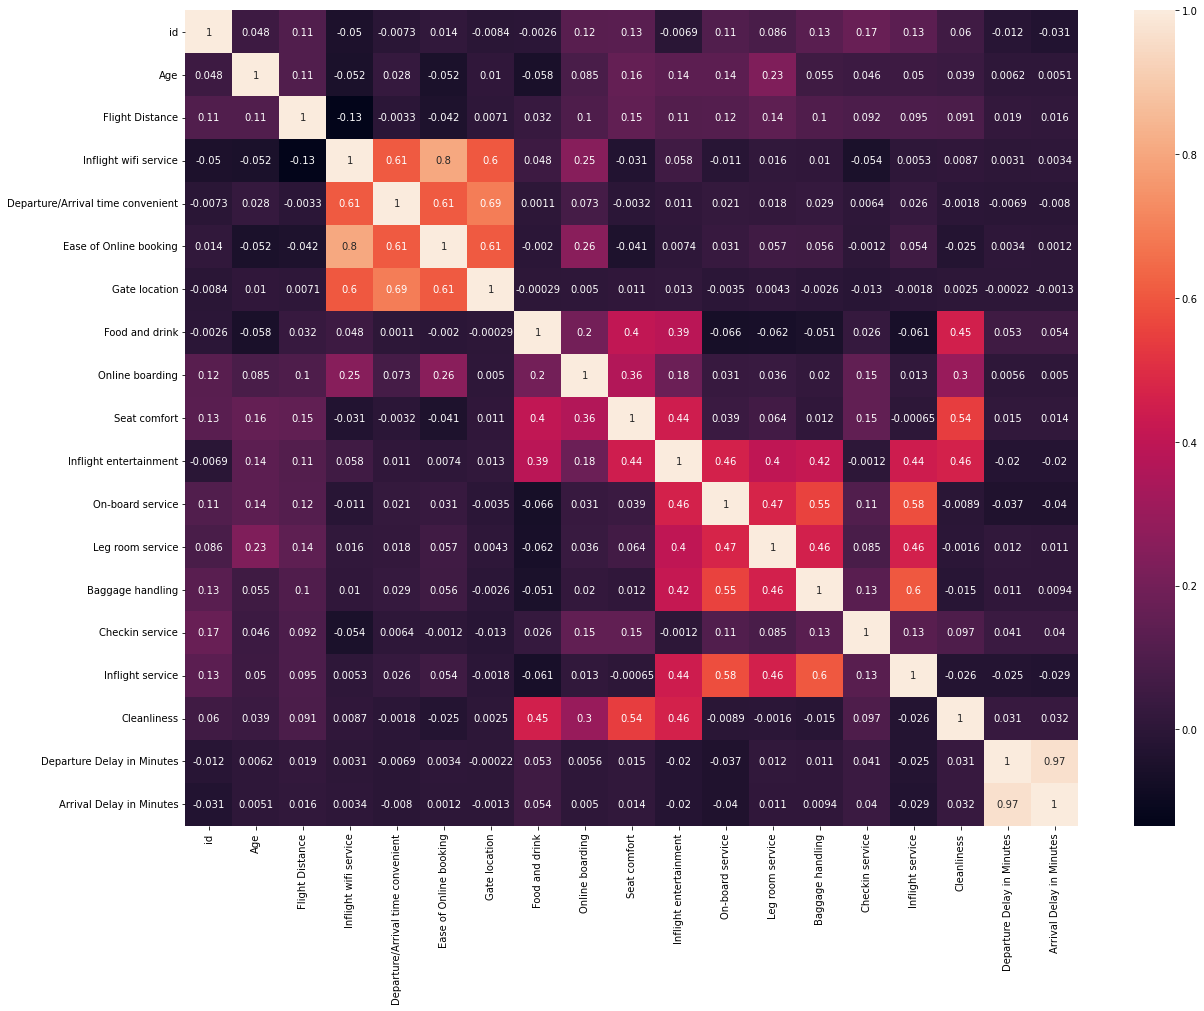

In [ ]:
# Correlation heatmap for satisfied customer features.
fig, ax = plt.subplots(figsize = (20,15))
mask=
sns.heatmap(df_s.corr(), annot = True)

<AxesSubplot:>

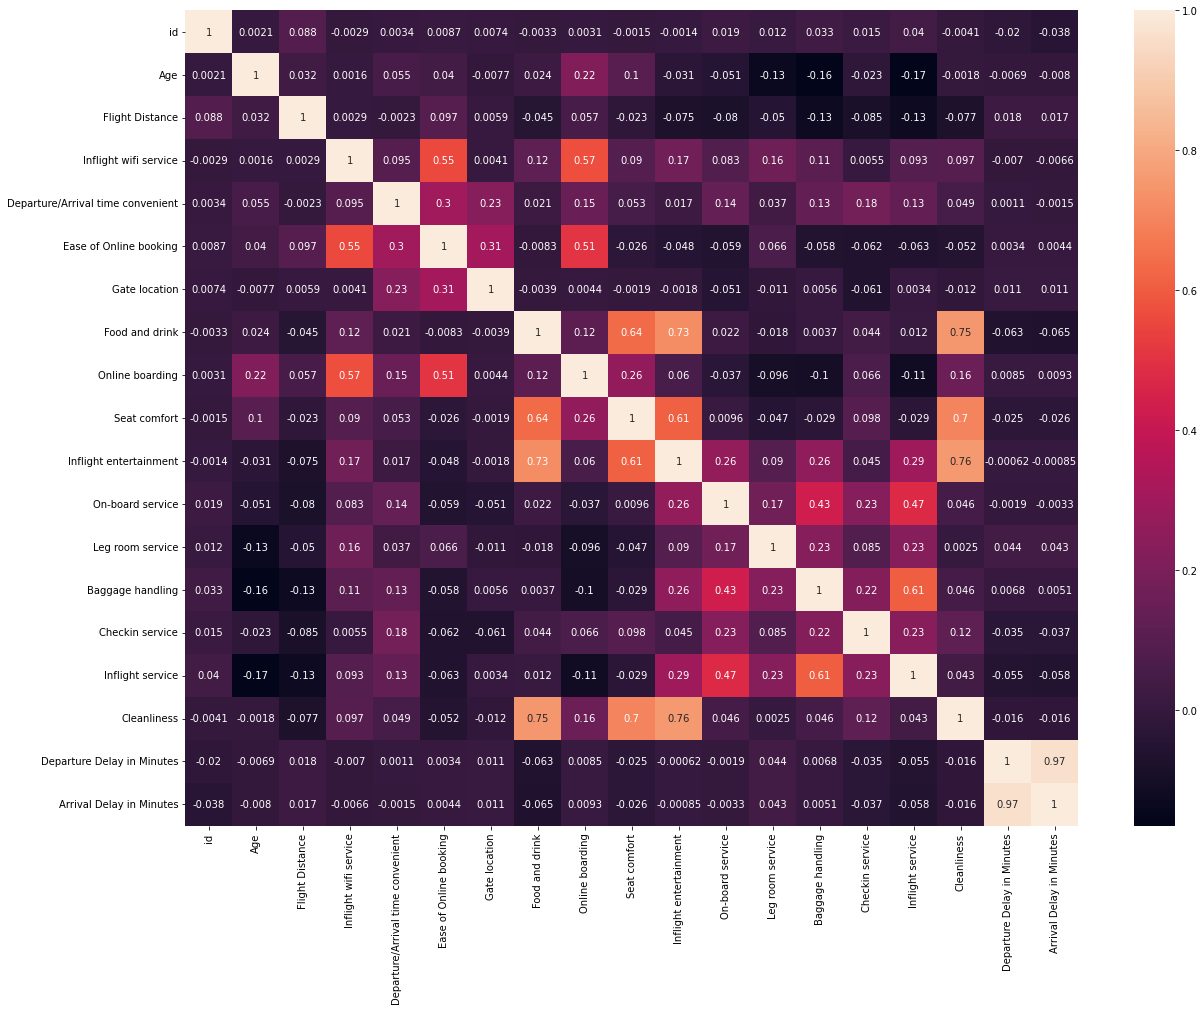

In [ ]:
# Correlation heatmap for neutral or disssatisfied customer features.
fig, ax = plt.subplots(figsize = (20,15))
sns.heatmap(df_d.corr(), annot = True)

Luckily, our data doesn't seem to have to many correlated variables, which means multi-collinearity should not be too much of a concern. There are two featues correlated highly with each other: 'Departure Delay in Minutes' and 'Arrival Delay in Minutes'. This makes logical sense as if the departure for a flight is delayed, so will the arrival. We should remove one of these features before modeling. Let's do that now.

In [ ]:
# Drop one of the two correlated features.
df = df.drop(['Arrival Delay in Minutes'], axis=1)
print(df.shape)

(129487, 23)


In [ ]:
#conclude, answering question

## Part 3: Modeling

The business leaders were impressed with the analysis.  

**They now want you to build a model
that can predict if a customer was not satisfied by their flight immediately after they submit a
survey. Customer service representatives are very busy so we need to prioritize who to reach
out to first.**  

- Using the data, build the best model you can given the data that does what the business
leaders are asking. Does this business case influence the model you ended up choosing? Be
sure to explain!
- How accurate is this model? (Use whatever accuracy metrics you think are relevant.)

Be sure to explain any assumptions you make and show all steps you took to get to your final
model.

First, we'll need to preprocess our data.

In [ ]:
# Import libraries.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Split features into X and y dataframes.
X = df.drop(columns=['satisfaction_v2', 'id']) # The id variable will not be helpful in making predictions.
y = df['satisfaction_v2']

# Split into train/test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# We first need to split our data into two dataframes of numerical and categorical data.
#X_train_numeric = X_train.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class'])
#X_test_numeric = X_test.drop(columns=['Gender', 'Customer Type', 'Type of Travel', 'Class'])
#X_train_categorical = X_train.drop(X_train.columns.difference(['Gender', 'Customer Type', 'Type of Travel', 'Class'], axis=1)
#X_test_categorical = X_test.drop(X_test.columns.difference(['Gender', 'Customer Type', 'Type of Travel', 'Class']), axis=1)

# Save the column names
#X_col = X_train_numeric.columns

In [ ]:
preprocess

In [ ]:
model

In [ ]:
feature importance

In [ ]:
conclude

In [ ]:
log SB contacts